In [1]:
import random

import networkx as nx
import osmnx as ox
import contextily as ctx
import matplotlib.pyplot as plt


ox.__version__
ox.settings.use_cache = True

In [2]:
# download/model a street network for New York City
G = ox.graph.graph_from_place("New York, New York, USA", network_type="drive")

In [3]:
# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.convert.to_digraph(G)

## Set Edge Weights and Capacity

Use a simple rule for now, just for illustration

Edge weight is a "cost" used in routing, commonly representing travel time, distance, or monetary cost for traveling from one node to its neighboring node.

OSM attributes that could be useful to define weight are: `length`, `maxspeed`, and `highway`.

-`length`: The physical distance of the edge, which OSMnx automatically computes (no missing value)
-`maxspeed`: The posted speed limit. If it is missing, we could refer to `highway` classification or other heuristics to impute
-`highway`: Road type classification, e.g. `motorway`, `primary`, and `residential`. This can help us determine default speed limits if `maxspeed` is absent.


Edge capacity is a quantity referring to maximum flow of vehicles that a road segment or an edge can carry per unit time. 

OSM attributes that could be helpful are: `lanes`, `highway`, and `maxspeed`.

-`lanes`: The number of lanes on that road segment. This feature is missing in value for significant portion of rows.

## Sample a Node and take its surrounding nodes up to certain distance (for visualization)

In [8]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,highway,ref,street_count,junction,railway,geometry
osmid,,,,,,,,
39076461,40.786345,-73.794748,motorway_junction,33,3,NaN,NaN,POINT (-73.79475 40.78635)
39076490,40.762429,-73.757091,motorway_junction,31W,3,NaN,NaN,POINT (-73.75709 40.76243)
39076504,40.753467,-73.744164,motorway_junction,30W,3,NaN,NaN,POINT (-73.74416 40.75347)
42421728,40.798048,-73.960044,traffic_signals,NaN,3,NaN,NaN,POINT (-73.96004 40.79805)
42421731,40.798654,-73.961474,traffic_signals,NaN,4,NaN,NaN,POINT (-73.96147 40.79865)


In [10]:
gdf_edges[['length', 'lanes', 'maxspeed', 'oneway', 'width', 'est_width']]

length lanes maxspeed  oneway width est_width
u           v           key                                                   
39076461    274283981   0    819.501666     2   50 mph    True   NaN       NaN
            42854803    0    268.144095   NaN      NaN    True   NaN       NaN
39076490    277672046   0    259.923487   NaN      NaN    True   NaN       NaN
            277672005   0    291.838695     3   50 mph    True   NaN       NaN
39076504    462124701   0    433.149850     1      NaN    True   NaN       NaN
...                                 ...   ...      ...     ...   ...       ...
12674920994 42843830    0     21.961624     2      NaN    True   NaN       NaN
            4205384289  0     55.832727     2      NaN    True   NaN       NaN
12695909141 596478662   0    194.773956     4   50 mph    True   NaN       NaN
12699204775 277482105   0    157.462944   NaN      NaN    True   NaN       NaN
            11939017657 0     18.985263   NaN      NaN    True   NaN       NaN

[139289 rows x 6 columns]

In [25]:
set(i for i in gdf_edges.highway.tolist() if isinstance(i, str))

{'busway',
 'living_street',
 'motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'residential',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link',
 'unclassified'}

In [6]:
# node = random.choice(list(G.nodes))

intersection_str = "476 5th Avenue, Manhattan, New York, USA"
lat, lon = ox.geocode(intersection_str)

node_id = ox.distance.nearest_nodes(D, lon, lat)

k = 10

# Suppose G is your MultiDiGraph and n is the starting node
distances = nx.single_source_shortest_path_length(G, node_id, cutoff=k)

# distances is a dict keyed by node with values = distance from n
reachable_nodes = list(distances.keys())

H = G.subgraph(reachable_nodes)

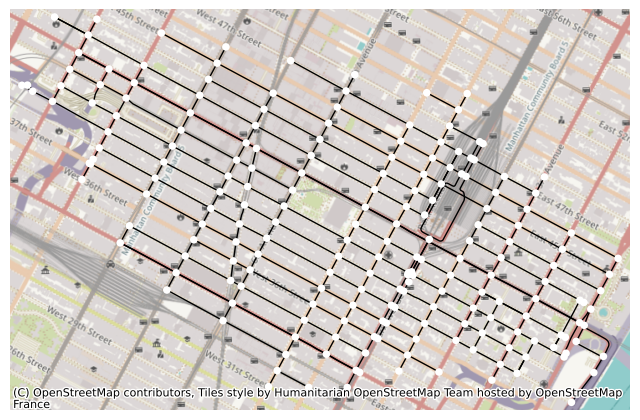

In [7]:
# project the subgraph to a projected CRS 
# so it aligns correctly with contextily basemaps
H_projected = ox.project_graph(H)

fig, ax = ox.plot.plot_graph(
    H_projected, 
    node_color="white", 
    node_size=30, 
    edge_color="black", 
    edge_linewidth=1, 
    show=False, 
    close=False
)

# Add a basemap (this fetches tiles from the web)
ctx.add_basemap(ax, crs=H_projected.graph["crs"])

plt.show()